In [39]:
import numpy as np

In [4]:
import torch as T
import torch.nn.functional as F
import torch.optim as optim
from dmp_ic import DMP_IC

import time
t0 = time.time()

T.cuda.set_device(1)

#net_path = "data/NetHEPT.npy"
net_path = "data/BA_100.npy"
#net_path = "data/baseline.npy"
IC = DMP_IC(net_path)

# True Greedy

In [129]:
from mc_ic import MC_IC
import numpy as np

def true_greedy(K):
    N = IC.N
    Seeds = []
    old_inf = 0

    for i in range(K):
        aug_inf = -1
        new_node = -1
        for n in range(N):
            if n not in Seeds:
                #S = T.zeros(N)
                #S[Seeds+[n]] = 1
                #inf = IC.run(S)[-1].item()
                inf = MC_IC(net_path, Seeds+[n], mc=1000)[-1]
                if inf-old_inf > aug_inf:
                    new_node = n
                    aug_inf = inf-old_inf
            #if (n+1)%10 == 0:
            #    print(n, "time={:.2f}s".format(time.time()-t0))
        Seeds += [new_node]
        old_inf += aug_inf


    #print("Seeds=", Seeds)
    #print("Inf={:.2f}".format(MC_IC(net_path, Seeds, mc=1000)[-1]))
    
    return MC_IC(net_path, Seeds, mc=1000)[-1]

In [131]:
true_greedy_re = []

for k in range(1, 20):
    true_greedy_re.append(true_greedy(k))

KeyboardInterrupt: 

# Greedy

In [2]:
def greedy(K):
    N = IC.N
    Seeds = []
    old_inf = 0

    for i in range(K):
        aug_inf = -1
        new_node = -1
        for n in range(N):
            if n not in Seeds:
                S = T.zeros(N)
                S[Seeds+[n]] = 1
                inf = IC.run(S)[-1].item()
                if inf-old_inf > aug_inf:
                    new_node = n
                    aug_inf = inf-old_inf
            #if (n+1)%10 == 0:
            #    print(n, "time={:.2f}s".format(time.time()-t0))
        Seeds += [new_node]
        old_inf += aug_inf

    from mc_ic import MC_IC
    import numpy as np

    #print("Seeds=", Seeds)
    #print("Inf={:.2f}".format(MC_IC(net_path, Seeds, mc=1000)[-1]))
    
    return MC_IC(net_path, Seeds, mc=1000)[-1]

In [5]:
greedy_re = []

for k in range(1, 20):
    greedy_re.append(greedy(k))

# Top_k

In [59]:
def top_k(k):
    K=k
    S = T.rand(IC.N, requires_grad=True)
    opt = optim.SGD([S], lr=0.01)

    for i in range(150):
        opt.zero_grad()
        idx = T.argsort(S, descending=True)
        Seed = S - (S[idx[K-1]] + S[idx[K]])/2
        Seed_list = T.sigmoid(Seed)
        Seed_list = K*Seed_list/Seed_list.sum()
        Sigmas = IC.run(Seed_list)

        loss = -Sigmas[-1]
        loss.backward()
        opt.step()

        #print(Seed_list)
        #print("Influence={:.4f}".format(-loss))

    #print(Seed_list)
    # Final...
    idx = T.argsort(S, descending=True)
    seed_list = idx[:K]
    seed_tensor = T.zeros(IC.N); seed_tensor[seed_list] = 1
    Sigmas = IC.run(seed_tensor)
    #print("Seeds = ", seed_list.tolist())
    #print("Inf = {}".format(MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]))
    
    return MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]

In [62]:
top_k_re = []
for k in range(1, 20):
    tmp = []
    for i in range(5):
        tmp.append(top_k(k))
    top_k_re.append(tmp)

In [63]:
re2 = np.array(top_k_re)

# Gumbel

In [64]:
def gumbel(k):
    K=k
    S = T.rand(IC.N, requires_grad=True)
    opt = optim.SGD([S], lr=0.01)

    for i in range(150):
        opt.zero_grad()
        idx = T.argsort(S, descending=True)
        Seed = S - (S[idx[K-1]] + S[idx[K]])/2
        logits = T.log(T.sigmoid(Seed))
        sample = T.nn.functional.gumbel_softmax(T.stack((logits, 1-logits)).t())
        Seed_list = sample[:, 1]
        Sigmas = IC.run(Seed_list)

        loss = -Sigmas[-1]
        loss.backward()
        opt.step()

        #print(Seed_list)
        #print("Influence={:.4f}".format(-loss))

    #print(Seed_list)
    # Final...
    idx = T.argsort(S, descending=True)
    seed_list = idx[:K]
    seed_tensor = T.zeros(IC.N); seed_tensor[seed_list] = 1
    Sigmas = IC.run(seed_tensor)
    #print("Seeds = ", seed_list.tolist())
    #print("Inf = {}".format(MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]))
    
    return MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]

In [65]:
gumbel_re = []
for k in range(1, 20):
    tmp = []
    for i in range(5):
        tmp.append(gumbel(k))
    print(tmp)
    gumbel_re.append(tmp)

[1.384, 2.17, 2.399, 1.614, 1.773]
[3.113, 2.211, 2.455, 4.927, 4.288]
[9.19, 3.864, 11.129, 4.336, 6.437]
[12.555, 7.444, 11.335, 7.497, 13.227]
[7.966, 8.991, 8.578, 7.658, 6.647]
[10.816, 19.082, 10.031, 15.153, 8.343]
[16.798, 9.367, 22.248, 10.203, 20.415]
[12.003, 13.33, 17.746, 14.218, 13.811]
[14.793, 17.031, 22.15, 19.843, 20.534]
[12.984, 12.346, 15.231, 20.807, 22.82]
[18.116, 14.621, 19.615, 17.523, 23.138]
[22.702, 22.347, 24.38, 14.224, 15.833]
[25.088, 16.657, 26.998, 23.718, 27.058]
[21.422, 24.08, 27.971, 15.618, 16.455]
[28.977, 28.766, 20.862, 23.481, 29.148]
[24.951, 31.065, 25.78, 35.362, 23.873]
[27.893, 35.903, 25.357, 23.429, 37.414]
[30.737, 27.447, 25.743, 36.543, 35.045]
[33.916, 29.875, 38.444, 36.146, 30.262]


In [66]:
re3 = np.array(gumbel_re)

# GCN

In [81]:
from model import GCNOnly
from torch_geometric.data import Data


In [105]:
def GCN_K(k):
    K=k
    lr = 0.01
    data = Data(x=IC.d.unsqueeze(1), edge_index=T.stack((IC.src_nodes, IC.tar_nodes)))
    model = GCNOnly(nfeat=1,
            nhid=32,
            nout=16)
    opt = optim.Adam(model.parameters(), lr=0.01)

    for i in range(150):
        opt.zero_grad()
        
        S = model(data).squeeze()
#         idx = T.argsort(S, descending=True)
#         Seed = S - (S[idx[K-1]] + S[idx[K]])/2
#         logits = T.log(T.sigmoid(Seed))
#         sample = T.nn.functional.gumbel_softmax(T.stack((logits, 1-logits)).t())
#         Seed_list = sample[:, 1]
        
#         Sigmas = IC.run(Seed_list)
        Sigmas = IC.run(S)

        loss = -Sigmas[-1] + T.pow(S.sum()-K, 2)
        loss.backward()
        opt.step()

        #print(Seed_list)
        #print("Influence={:.4f}".format(-loss))

    #print(Seed_list)
    # Final...
    idx = T.argsort(S, descending=True)
    seed_list = idx[:K]
    seed_tensor = T.zeros(IC.N); seed_tensor[seed_list] = 1
    Sigmas = IC.run(seed_tensor)
    #print("Seeds = ", seed_list.tolist())
    #print("Inf = {}".format(MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]))
    
    return MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]

In [119]:
gcn_re = []
for k in range(1, 20):
    tmp = []
    for i in range(10):
        tmp.append(GCN_K(k))
    print(tmp)
    gcn_re.append(tmp)

[8.479, 8.389, 10.432, 10.519, 10.449, 10.405, 10.519, 10.79, 10.749, 10.478]
[19.197, 18.874, 18.923, 19.14, 19.036, 19.281, 19.082, 17.961, 17.803, 17.296]
[24.463, 24.932, 24.579, 24.528, 25.113, 25.21, 24.876, 24.613, 24.506, 24.039]
[27.591, 27.669, 28.189, 28.183, 27.515, 27.664, 28.111, 27.89, 27.177, 28.017]
[31.019, 30.698, 30.755, 31.277, 31.056, 30.605, 30.279, 30.484, 30.347, 31.042]
[33.317, 33.46, 33.408, 33.308, 33.269, 33.218, 33.437, 32.713, 33.357, 33.266]
[35.655, 35.691, 35.602, 35.521, 35.577, 35.44, 35.487, 35.572, 35.398, 35.074]
[37.578, 37.477, 37.517, 37.169, 37.46, 37.957, 37.831, 37.39, 37.064, 37.421]
[38.936, 38.737, 38.52, 38.923, 38.806, 38.585, 39.042, 38.816, 38.55, 37.989]
[40.189, 40.049, 40.141, 40.188, 40.516, 39.886, 39.893, 40.349, 40.153, 40.051]
[41.238, 41.342, 41.674, 41.297, 41.066, 42.103, 41.884, 41.519, 41.15, 41.472]
[43.182, 43.268, 42.879, 43.062, 43.213, 43.126, 42.502, 43.116, 42.032, 43.237]
[43.42, 44.434, 43.831, 44.664, 43.958, 4

In [120]:
re4 = np.array(gcn_re)

# Penal

In [121]:
def Penal_K(k):
    K=k
    lr = 0.01
    S = T.rand(IC.N, requires_grad=True)
    opt = optim.SGD([S], lr=lr)

    for i in range(150):
        opt.zero_grad()
        
        Seed = T.sigmoid(S)

        Sigmas = IC.run(Seed)

        loss = -Sigmas[-1] + T.pow(Seed.sum()-K, 2)
        loss.backward()
        opt.step()

        #print(Seed_list)
        #print("Influence={:.4f}".format(-loss))

    #print(Seed_list)
    # Final...
    idx = T.argsort(S, descending=True)
    seed_list = idx[:K]
    seed_tensor = T.zeros(IC.N); seed_tensor[seed_list] = 1
    Sigmas = IC.run(seed_tensor)
    #print("Seeds = ", seed_list.tolist())
    #print("Inf = {}".format(MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]))
    
    return MC_IC(net_path, seed_list.tolist(), mc=1000)[-1]

In [122]:
penal_re = []
for k in range(1, 20):
    tmp = []
    for i in range(10):
        tmp.append(Penal_K(k))
    print(tmp)
    penal_re.append(tmp)

[10.699, 8.199, 10.291, 10.783, 10.576, 10.605, 10.164, 10.22, 10.632, 10.236]
[19.356, 19.054, 19.139, 19.285, 18.989, 18.827, 18.838, 19.164, 18.987, 19.207]
[23.657, 25.173, 22.824, 25.001, 24.795, 22.945, 21.12, 24.849, 24.784, 24.69]
[27.675, 28.217, 27.544, 28.239, 25.468, 27.944, 26.487, 26.486, 27.766, 27.538]
[30.174, 30.998, 30.473, 30.638, 30.644, 30.098, 31.32, 30.387, 31.125, 30.387]
[32.632, 32.193, 33.295, 33.553, 33.438, 32.805, 32.839, 33.34, 33.685, 32.597]
[35.017, 35.469, 35.818, 35.829, 34.755, 34.377, 35.507, 34.738, 35.296, 35.006]
[36.692, 37.587, 37.057, 37.474, 36.854, 37.255, 36.697, 36.99, 36.745, 37.485]
[38.735, 39.18, 39.56, 38.597, 38.845, 38.034, 39.105, 39.527, 37.216, 38.964]
[39.06, 40.889, 41.684, 39.42, 40.511, 41.065, 39.957, 41.307, 39.157, 40.543]
[41.501, 41.982, 41.896, 40.658, 41.209, 43.024, 41.173, 41.817, 41.93, 40.824]
[42.242, 44.246, 42.923, 42.864, 42.958, 44.091, 40.572, 43.997, 43.059, 41.644]
[44.348, 43.47, 43.897, 44.422, 43.604, 

In [123]:
re5 = np.array(penal_re)

# PLT

In [124]:
import matplotlib.pyplot as plt

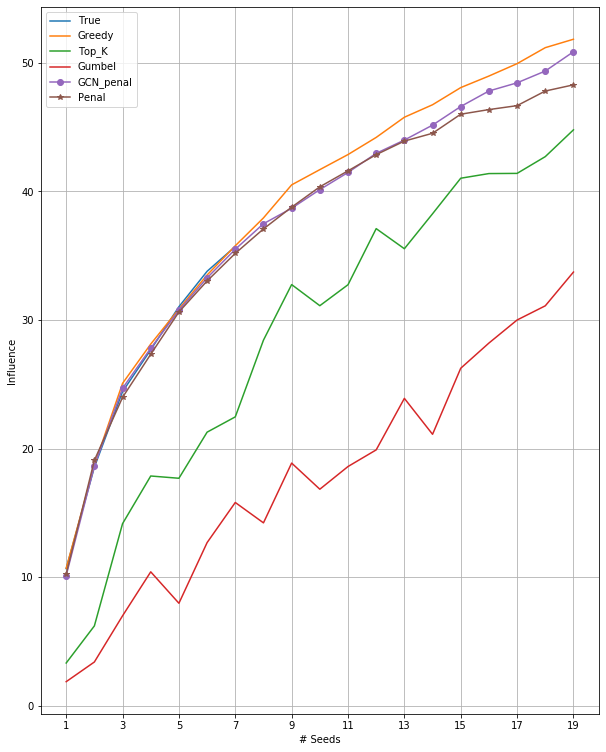

In [136]:
plt.figure(figsize=(10,13))
plt.plot(range(1, len(true_greedy_re)+1), np.array(true_greedy_re))
plt.plot(range(1, 20), np.array(greedy_re))
plt.plot(range(1, 20), np.mean(re2, axis=1))
plt.plot(range(1, 20), np.mean(re3, axis=1))
plt.plot(range(1, 20), np.mean(re4, axis=1), marker="o")
plt.plot(range(1, 20), np.mean(re5, axis=1), marker="*")

plt.xticks(range(1, 20, 2))
plt.legend(["True", "Greedy", "Top_K", "Gumbel", "GCN_penal", "Penal"])
plt.xlabel("# Seeds")
plt.ylabel("Influence")

plt.grid(True)
plt.show()